In [1]:
from keras import Sequential
from keras.layers import SimpleRNN, LSTM, GRU, Dense, TimeDistributed

In [61]:
import utils
import autoregression as ar
import neural_network as nn

In [162]:
# Setting up pyplot runtime configuration

from matplotlib.ticker import MaxNLocator

SMALL = 14
MEDIUM = 16
LARGE = 20
THICK = 4
THIN = 3
WIDE_FIG = (20,7.5)
TWO_TIMES_TWO = (20,15)
SMALL_FIG = (6,6)
OPACITY = .25


plt.style.context('fivethirtyeight')
plt.rc('axes', facecolor='#E6E6E6', edgecolor='black', axisbelow=True, grid=True)
plt.rc('grid', color='white', linestyle='solid')
plt.rc('lines', linewidth=THIN)

plt.rc('font', size=SMALL, weight='bold')          # default text sizes
plt.rc('axes', titlesize=MEDIUM)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM)    # legend fontsize
plt.rc('figure', titlesize=LARGE)  # fontsize of the figure title

COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [239]:
temperature = utils.parse_file('data/pcu1/Supply trafo A winding 2W temp.csv', 'temp')
temperatureX = utils.parse_file('data/pcu1/Supply trafo A winding 2U temp.csv', 'tempX')
temperatureY = utils.parse_file('data/pcu1/Supply trafo A winding 2V temp.csv', 'tempY')
auxiliaries = utils.parse_file('data/pcu1/AUX ON from PCU.csv', 'aux_on')
current = utils.parse_file('data/pt1/i1.csv', 'I')

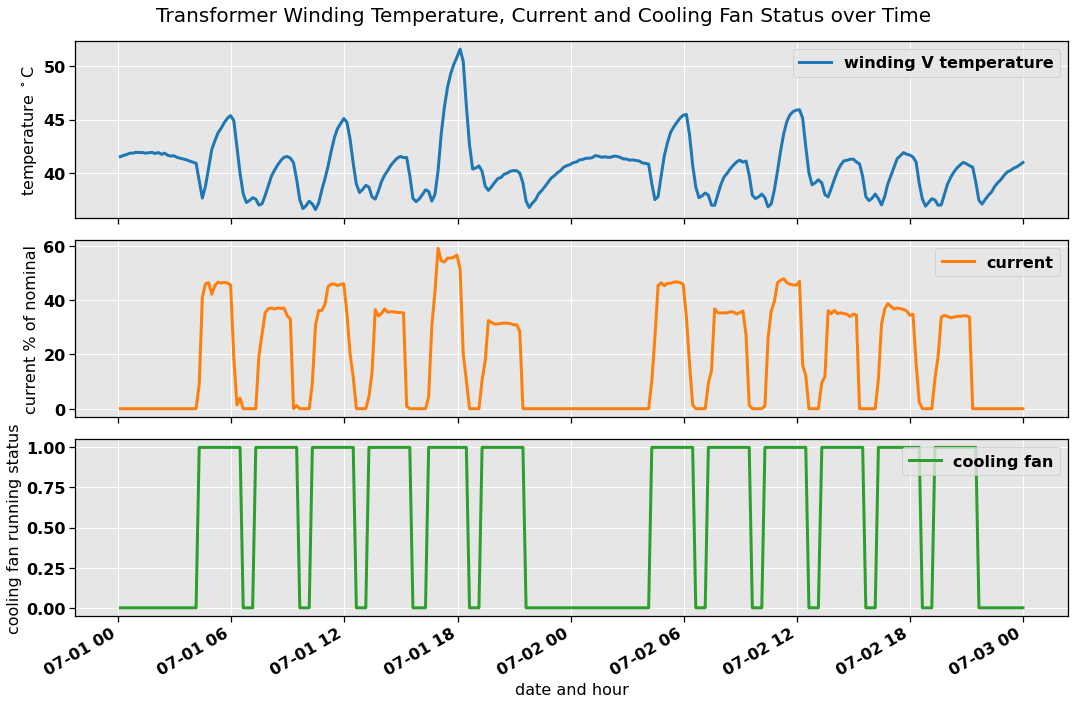

In [300]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15,10), sharex=True)
fig.suptitle('Transformer Winding Temperature, Current and Cooling Fan Status over Time', fontsize=LARGE)

X, y = ar.prep_current_temp_model_dataset(auxiliaries, current, temperature, temperatureX, temperatureY, 0)
start='2018-07-01 00:00:00'
end='2018-07-03 00:00:00'

ax = axes[0]
X['tempX'][start:end].plot(ax=ax, label='winding V temperature')
ax.set_ylabel('temperature $^\circ$C')
ax.legend(loc='upper right')

ax = axes[1]
(X['I'] / 630 * 100)[start:end].plot(ax=ax, color=COLORS[1], label='current')
ax.set_ylabel('current % of nominal')
ax.legend(loc='upper right')

ax = axes[2]
X['aux_on'][start:end].plot(ax=ax, color=COLORS[2], label='cooling fan')
ax.set_ylabel('cooling fan running status')
ax.set_xlabel('date and hour')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

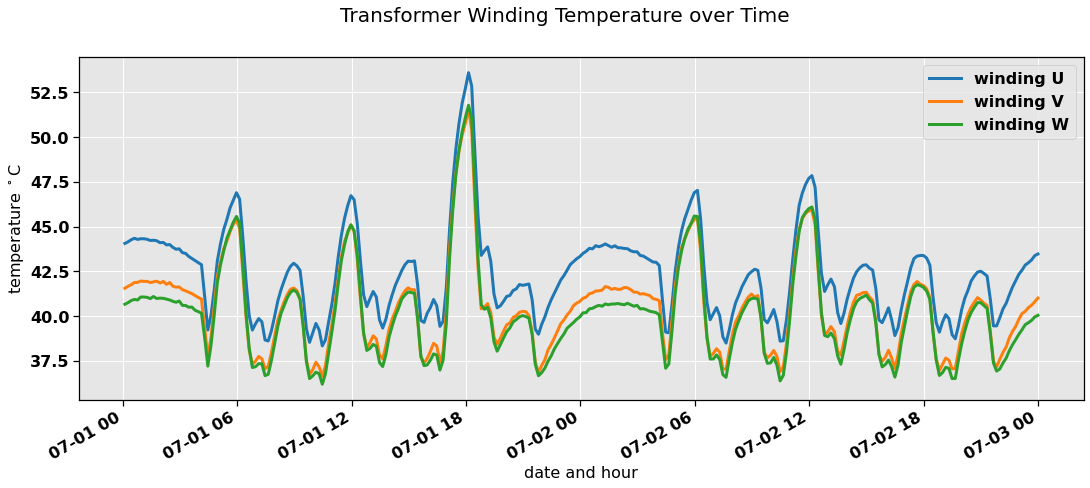

In [307]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18,7))
fig.suptitle('Transformer Winding Temperature over Time', fontsize=LARGE)

start='2018-07-01 00:00:00'
end='2018-07-03 00:00:00'

ax = axes
temperatureY[start:end].plot(ax=ax)
temperatureX[start:end].plot(ax=ax)
temperature[start:end].plot(ax=ax)
ax.set_xlabel('date and hour')
ax.set_ylabel('temperature $^\circ$C')
ax.legend(['winding U', 'winding V', 'winding W'])

plt.show()

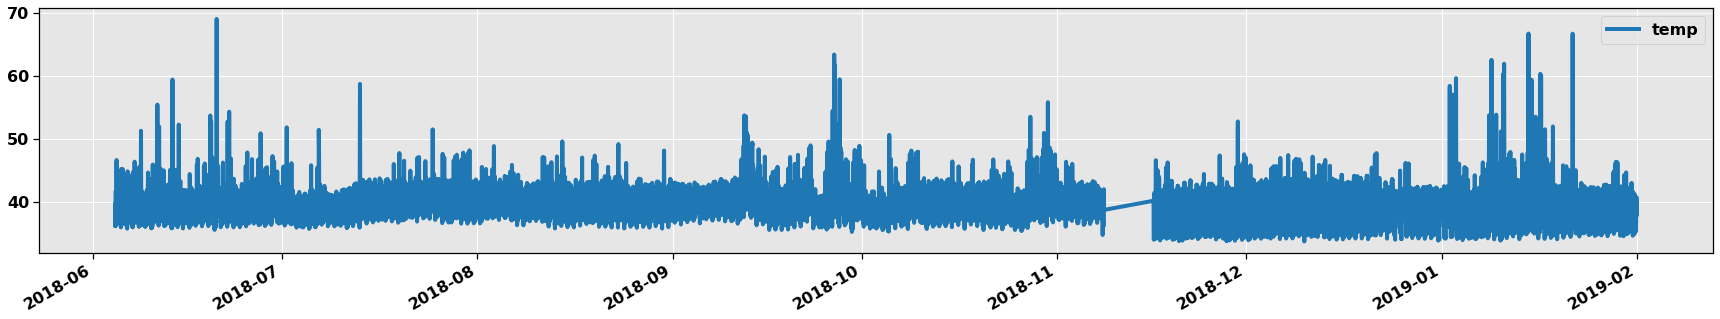

In [143]:
temperature[None:'2019-02-01 00:00:00'].plot(figsize=(30,5))
plt.show()

In [200]:
X, y = ar.prep_current_model_dataset(auxiliaries, current, temperature, 9)
X.head(0)

,aux_on,aux_off,I,I2,temp__1,temp__2,temp__3,temp__4,temp__5,temp__6,temp__7,temp__8,temp__9


In [261]:
X, y = ar.prep_current_temp_model_dataset(auxiliaries, current, temperatureX, temperature, temperatureY, 0)
X.head(1)

,aux_on,aux_off,I,I2,temp,tempY
2018-06-04 12:20:00,1.0,0.0,164.600006,27093.162009,39.519348,41.284042


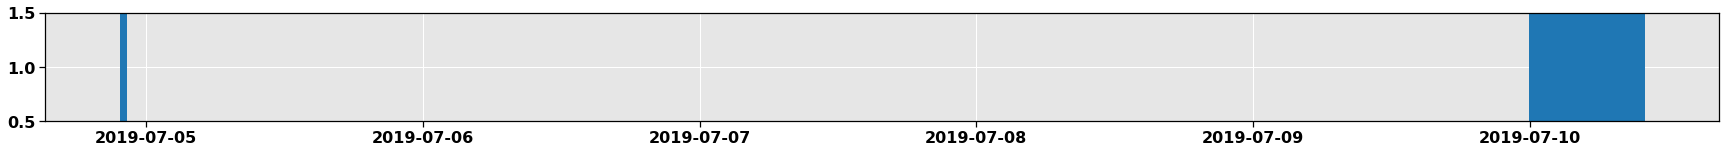

In [265]:
T = utils.sample_gaps(X['2019-01-01 00:00:00':'2019-01-31 00:00:00'])
T = utils.sample_gaps(X_test)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(30,2))
#axes.stem(T.index, T['gap'], markerfmt=' ', basefmt=' ')
axes.eventplot(T.index, orientation='horizontal')
axes.set_ylim(.5,1.5)
plt.show()

In [211]:
t0

41.0368499755859

R2=0.994, MSE=3.449e-02


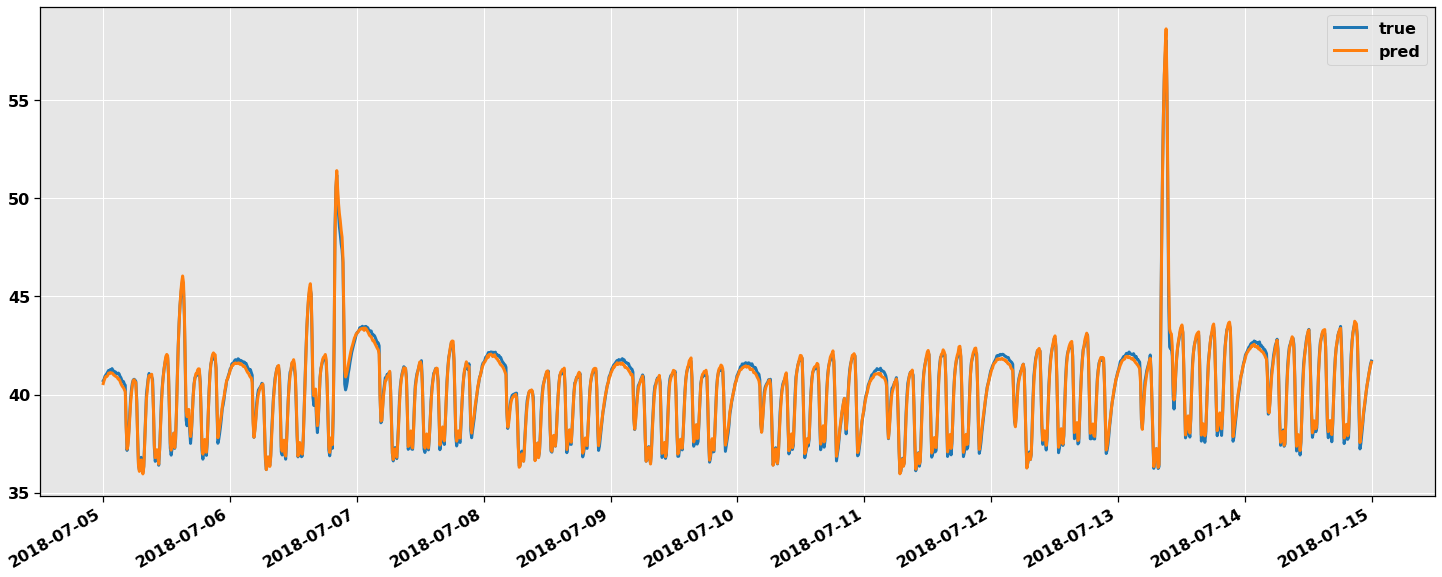

,aux_on,aux_off,I,I2,temp,tempY
0,0.151075,0.224353,0.001683,1.392631e-07,0.489615,0.484018


In [270]:
start = None
end = '2018-08-01 00:00:00'
X_train, y_train = X[start:end].copy(), y[start:end].copy()

start='2018-07-05 00:00:00'
end='2018-07-15 00:00:00'
X_test, y_test = X[start:end].copy(), y[start:end].copy()

#X_train, X_test = ar.scale(X_train, X_test, cols=['I', 'I2', 'tempX', 'tempY', 'temp__1'])

coeffs = ar.ols(X_train, y_train)

t0 = y_test['tempX'][0]
y_pred = ar.evaluate(coeffs, X_test, t0)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25,10))
ax = axes
y_test.plot(ax=ax)
y_pred.plot(ax=ax)


r2 = skl.metrics.r2_score(y_test, y_pred)
mse = skl.metrics.mean_squared_error(y_test, y_pred)
print(f'R2={r2:.3f}, MSE={mse:.3e}')

ax.legend(['true', 'pred'])
plt.show()
coeffs

In [5]:
def reshape(X, y, batch_size):
    n, p = X.shape
    features = np.empty((n-batch_size, batch_size, p))
    targets = np.empty((n-batch_size, batch_size, 1))
    for i in range(n-batch_size):
        features[i,:,:] = X[i:i+batch_size,:]
        targets[i,:,0] = y[i:i+batch_size,0]
    return features, targets

def reshape2(X, y, batch_size):
    n, p = X.shape
    features = np.empty((n-batch_size, batch_size, p))
    targets = np.empty((n-batch_size, 1, 1))
    for i in range(n-batch_size):
        features[i,:,:] = X[i:i+batch_size,:]
        targets[i,0,0] = y[i+batch_size,0]
    return features, targets

In [6]:
X, y = nn.prep_current_model_dataset(auxiliaries, current, temperature)

In [7]:
start=None
end='2018-08-01 00:00:00'
X_train, y_train = X[start:end].to_numpy(), y[start:end].to_numpy()
n, p = X_train.shape

start='2019-01-13 00:00:00'
end='2019-01-25 00:00:00'
X_test, y_test = X[start:end].to_numpy(), y[start:end].to_numpy()
X_train.shape, X_test.shape

((8166, 3), (1717, 3))

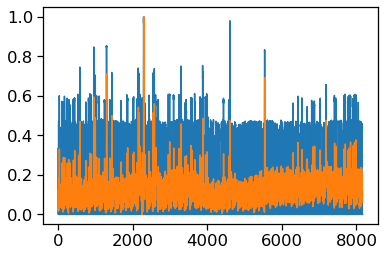

In [8]:
scaler = skl.preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled[:,0] = X_train[:,0]
X_test_scaled[:,0] = X_test[:,0]

ymin, ymax = y_train.min(), y_train.max()
scaler.fit(y_train)
y_train_scaled = scaler.transform(y_train)
y_test_scaled = scaler.transform(y_test)

scaler.fit(y_train_scaled)
y_train_scaled = scaler.transform(y_train_scaled)
y_test_scaled = scaler.transform(y_test_scaled)

plt.plot(X_train_scaled[:,1])
plt.plot(y_train_scaled[:,0])
plt.show()

In [9]:
sample_size = 24
X_train_reshaped, y_train_reshaped = reshape(X_train_scaled, y_train_scaled, sample_size)
X_test_reshaped, y_test_reshaped = reshape(X_test_scaled, y_test_scaled, sample_size)

In [26]:
model = Sequential([
    LSTM(30, return_sequences=True, input_shape=(sample_size, p), dropout=.0, recurrent_dropout=.2, unroll=True),
    LSTM(18, return_sequences=True, unroll=True),
    Dense(sample_size)
])
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 24, 30)            4080      
_________________________________________________________________
lstm_7 (LSTM)                (None, 24, 18)            3528      
_________________________________________________________________
dense_3 (Dense)              (None, 24, 24)            456       
Total params: 8,064
Trainable params: 8,064
Non-trainable params: 0
_________________________________________________________________


In [33]:
epochs = 1
batch_size = 50
model.fit(X_train_reshaped, y_train_reshaped, epochs=epochs, batch_size=batch_size, shuffle=False, verbose=True)

163/163 [==============================] - 13s 80ms/step - loss: 0.0016


R2=0.947, MSE=1.010e+00


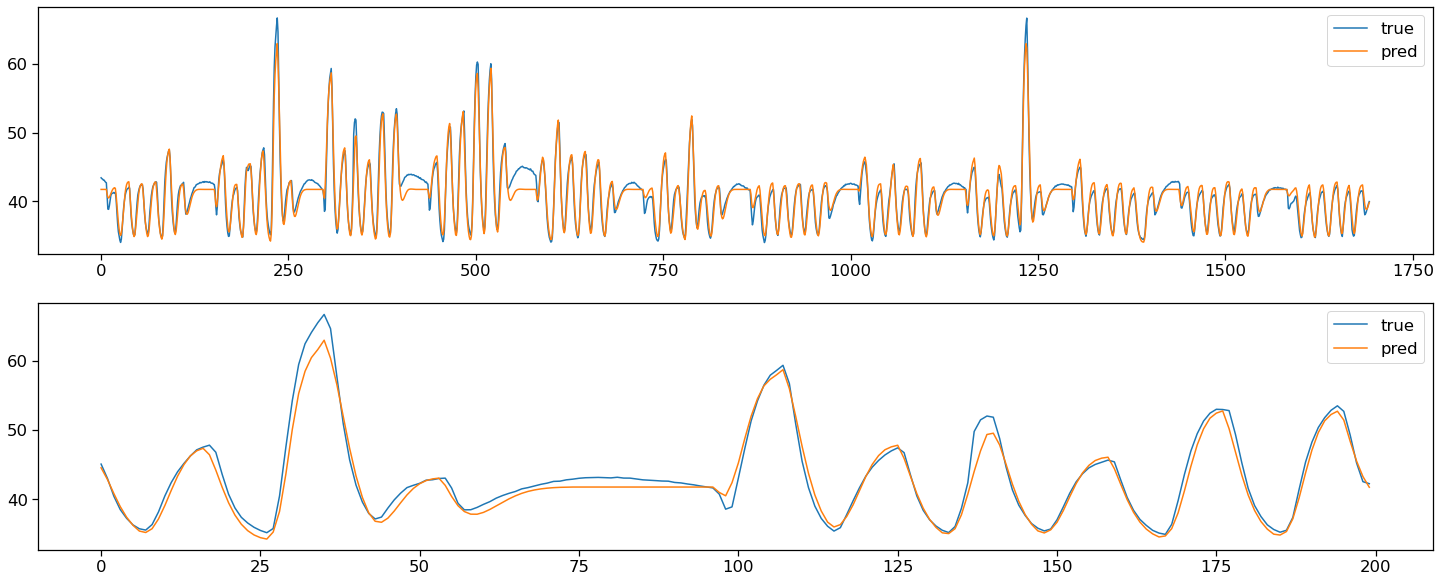

In [34]:
y_pred_raw = model.predict(X_test_reshaped)
y_pred = y_pred_raw[:,-1,0].reshape(-1,1)
y_pred = y_pred*(ymax - ymin) + ymin
shift = 1
y_true = y_test[sample_size-shift:-1*shift if shift else len(y_true)-1]


r2 = skl.metrics.r2_score(y_true, y_pred)
mse = skl.metrics.mean_squared_error(y_true, y_pred)
print(f'R2={r2:.3f}, MSE={mse:.3e}')

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(25,10))
ax = axes[0]
ax.plot(y_true)
ax.plot(y_pred)
ax.legend(['true', 'pred'])

ax = axes[1]
start, end = 200, 400
ax.plot(y_true[start:end])
ax.plot(y_pred[start:end])
ax.legend(['true', 'pred'])

plt.show()